In [1]:
%matplotlib inline
import os,sys
from IPython.display import clear_output

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# python wrapper for cpp code
from qihmc import Ising

# MDS problem to qubo map (install the other repo)
from qlp.mds.qubo import get_mds_qubo, QUBO_to_Ising
from qlp.mds.graph_tools import get_plot_mpl
#import qlp.mds.graph_tools as gt
from qlp.mds import graph_tools as gt
#from qlp.mds.qubo import get_mds_qubo
#from qlp.mds.mds_qlpdb import QUBO_to_Ising

from qlpdb.graph.models import Graph as graph_Graph
from qlpdb.experiment.models import DWaveExperiment as experiment_Experiment
from qlpdb.data.models import Data as data_Data

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Below is my simple hack at a progress bar.  I need this so that I can gauge if my runs got stuck in a local minimum or not. . .

In [2]:
# my simple progress bar. . .
def update_progress(progress):
    bar_length = 40
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [21]:
# available graphs--choose one of these options
# vertices = 4, 10, 50, 100
total_vertices = 10

5


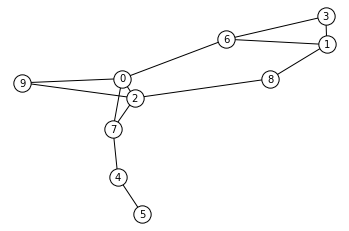

6


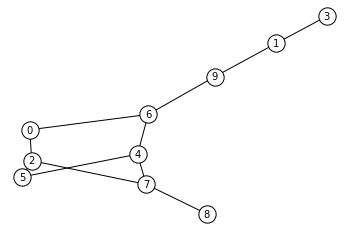

7


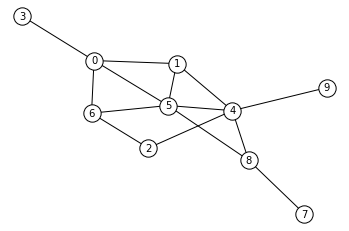

8


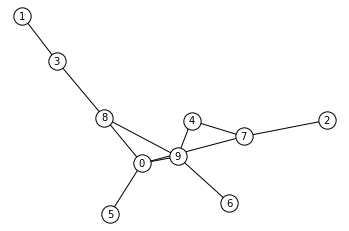

9


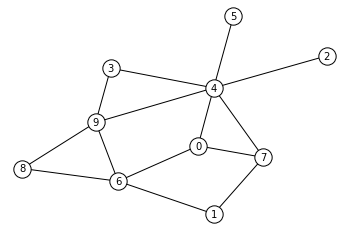

In [22]:
# this makes some pretty pictures
graphs = graph_Graph.objects.filter(total_vertices=total_vertices)
for idx, graph in enumerate(graphs):
    # plot graph
    adjacency_map = graph.adjacency
    gt.get_plot(adjacency_map, directed=False)
    print(graph.id)
    plt.show()

In [23]:
# Choose graph to read out (these numbers are next to each graph figure above)
graph_id = 6

In [24]:
# This gets info about the D-Wave run for this particular graph
for idx, experiment in enumerate(experiment_Experiment.objects.filter(graph_id = graph_id)):
    experiment_id = experiment.id
    print(experiment_id)
    print(experiment)
    

# Print QUBO and Ising information for this system
penalty = float(experiment_Experiment.objects.get(id=experiment_id).p)
adjacency_map = {tuple(edge) for edge in graph_Graph.objects.get(id = graph_id).adjacency}
qubo = get_mds_qubo(adjacency_map, penalty=penalty, directed=False, triangularize=True, dtype="d")
print("QUBO formulation")
print(qubo.todense())
J, h, c = QUBO_to_Ising(qubo.todense().tolist())
print("Ising formulation")
print(J)
print(h)
print(c)
offset = c + penalty*total_vertices
#data_Data.objects.filter(experiment_id = experiment_id)

6
DWaveExperiment[Experiment](machine=Advantage_system1.1, settings={'num_reads': 1000, 'auto_scale': True, 'answer_mode': 'raw', 'annealing_time': 800, 'chain_strength': 4.0, 'readout_thermalization': 0, 'programming_thermalization': 1000, 'num_spin_reversal_transforms': 0}, settings_hash=c8327d223192b2143cc7e5950cb42e72, p=2.00, chain_strength=4.0, tag=FixEmbedding_Binary_0_0_z0)
QUBO formulation
[[-5.  0.  8.  0.  4.  4.  8.  4.  0.  4. -4. -8.  0.  0. -4. -8.  0.  0.
   0.  0.  0. -4. -8.  0.  0.  0.  0.  0.]
 [ 0. -5.  0.  8.  0.  0.  4.  0.  0.  8.  0.  0. -4. -8.  0.  0. -4.  0.
   0.  0.  0.  0.  0.  0.  0.  0. -4. -8.]
 [ 0.  0. -7.  0.  8.  8.  4.  8.  4.  0. -4. -8.  0.  0. -4. -8.  0.  0.
   0. -4. -8.  0.  0. -4. -8.  0.  0.  0.]
 [ 0.  0.  0. -3.  0.  0.  0.  0.  0.  4.  0.  0. -4. -8.  0.  0. -4.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -7.  8.  8.  8.  4.  4.  0.  0.  0.  0.  0.  0.  0. -4.
  -8. -4. -8. -4. -8. -4. -8.  0.  0.  0.]
 [ 0.  0.  0.

Add parameters used for ising model

In [25]:
init_beta=.2  # this is the initial hot temperature to start the annealing process
beta = 2.0    # this is the final 'cold' temperature
md_steps = 10   # for 4 vertices use 8, 10 vertices use 10, 50 vertices use 22, 100 vertices use 30
ergodicity_jumps = -100  # negative here means that we do not do any ergodicity jumps
save_frequency = 10  # this really means that we take measurements every 10th trajectory during production

ising = Ising(J, h, offset, beta, md_steps, ergodicity_jumps)

('J =', array([[-0., -0., -2., -0., -1., -1., -2., -1., -0., -1.,  1.,  2., -0.,
        -0.,  1.,  2., -0., -0., -0., -0., -0.,  1.,  2., -0., -0., -0.,
        -0., -0.],
       [-0., -0., -0., -2., -0., -0., -1., -0., -0., -2., -0., -0.,  1.,
         2., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
         1.,  2.],
       [-2., -0., -0., -0., -2., -2., -1., -2., -1., -0.,  1.,  2., -0.,
        -0.,  1.,  2., -0., -0., -0.,  1.,  2., -0., -0.,  1.,  2., -0.,
        -0., -0.],
       [-0., -2., -0., -0., -0., -0., -0., -0., -0., -1., -0., -0.,  1.,
         2., -0., -0.,  1., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
        -0., -0.],
       [-1., -0., -2., -0., -0., -2., -2., -2., -1., -1., -0., -0., -0.,
        -0., -0., -0., -0.,  1.,  2.,  1.,  2.,  1.,  2.,  1.,  2., -0.,
        -0., -0.],
       [-1., -0., -2., -0., -2., -0., -1., -2., -0., -0., -0., -0., -0.,
        -0.,  1.,  2., -0.,  1.,  2.,  1.,  2., -0., -0., -0., -0., -0.,
        -0., -0.],
  

Now do the runs . . .

In [26]:
# arrays to store the obserables
energies=[]
contEnergies=[]
spins=[]
contSpins=[]

n_therm = 4000 # this is the number of 'cooling' steps
numOfMeasurements = 1000 # self-explanatorz
n_trajectories = 1000  # number of trajectories per measurement

currentMeasurement = 0
while currentMeasurement < numOfMeasurements:
    # first cool from initial 'hot' temperature
    ising.anneal(init_beta,beta, n_therm, md_steps) 
    
    # now due production run at target 'cold' temperature
    ising.run_hmc(beta,n_trajectories,md_steps,ergodicity_jumps,save_frequency)
    
    # now I calculate some obserables
    psi = np.mean(ising.configs, axis=0) / np.sqrt(ising.beta) - ising.k
    pgs = np.floor(psi+.5)  # this takes the spins to their nearest integer
    norm = pgs @ pgs
    
    # sometimes the solution is not a valid spin solution, so here I check for valid spin solutions
    if np.floor(norm+.5) == len(pgs):  # if valid, I store solution and its obserables
        energies.append(pgs @ J @ pgs + h @ pgs + offset)
        spins.append(pgs)
        contEnergies.append(np.mean(ising.energy))
        contSpins.append(psi)
        currentMeasurement += 1
        update_progress(currentMeasurement / numOfMeasurements)
        
    # I repeat until I have number of measurements = numOfMeasurements 
update_progress(1)

# here I save the data into text files (yes, I know, not sophisticated at all)
#np.savetxt('energies'+str(total_vertices)+'_vertices_graphID_'+str(graph_id)+'.txt',np.array(energies))
#np.savetxt('spins'+str(total_vertices)+'_vertices_graphID_'+str(graph_id)+'.txt',np.array(spins))
#np.savetxt('contEnergies'+str(total_vertices)+'_vertices_graphID_'+str(graph_id)+'.txt',np.array(contEnergies))
#np.savetxt('contSpins'+str(total_vertices)+'_vertices_graphID_'+str(graph_id)+'.txt',np.array(contSpins))

Progress: [########################################] 100.0%


# Egs =  4.0  happened  16  times
# Prob. of Success =  0.016


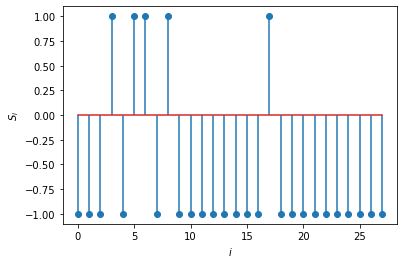

In [31]:
# here I print out some info on the lowest energy state that was calculated
egs = min(energies)
numOfEgs=0
egs_indices = []
for i in range(len(energies)):
    if energies[i]==egs: 
        numOfEgs += 1
        egs_indices.append(i)
print("# Egs = ",egs, " happened ", numOfEgs, " times")
print("# Prob. of Success = ", numOfEgs*1.0/len(energies))

# here is an example of the spin configuration for the lowest energy found
randomIndex = np.random.randint(len(egs_indices))# I choose some random low energy state
plt.stem(np.array([i for i in range(ising.Lambda)]),
         spins[egs_indices[randomIndex]],
         use_line_collection=True)

plt.xlabel(r'$i$')
plt.ylabel(r'$S_i$');

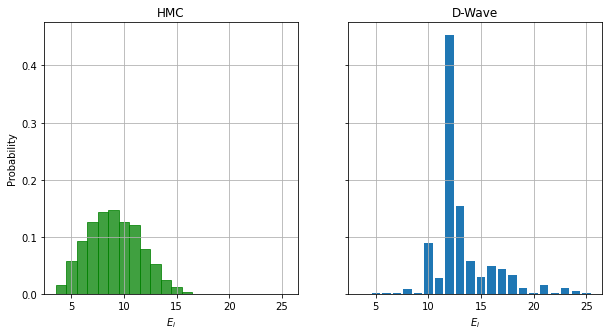

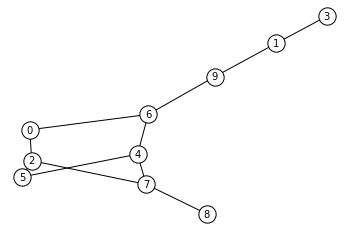

In [28]:
# the histogram of the data
energy = dict()
for row in data_Data.objects.filter(experiment_id = experiment_id):
    if row.energy in energy:
        energy[row.energy] += 1
    else:
        energy[row.energy] = 1
x = np.sort(list(energy.keys()))
y = [energy[i] for i in x]

fig, ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))

ax[0].hist(energies, [-.5 + i for i in range(int(min(energies)),int(max(energies))+1)], 
                            edgecolor='Green', density=1, facecolor='green', alpha=0.75)
ax[1].bar(x=x, height=np.array(y)/(1.*sum(y)));

ax[0].set_xlabel(r'$E_i$')
ax[0].set_title(r'HMC')
ax[1].set_xlabel(r'$E_i$')
ax[1].set_title(r'D-Wave')
ax[0].set_ylabel('Probability')
ax[0].grid(True)
ax[1].grid(True);

#plt.savefig(str(total_vertices)+'_vertices_graphID_'+str(graph_id)+'.png')

for idx, graph in enumerate(graphs):
    # plot graph
    if graph_id==graph.id:
        adjacency_map = graph.adjacency
        gt.get_plot(adjacency_map, directed=False)
        break

#plt.savefig(str(total_vertices)+'_vertices_graphID_'+str(graph_id)+'_connectivity.png')